In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import cv2

In [2]:
# 📥 Step 1: Load the labeled pose data
pose_df = pd.read_csv('../data/output/pose_data.csv')  # Contains frame, x_0, y_0, ..., z_n
labels_df = pd.read_csv('../data/output/manual_labels.csv')  # Contains shot_id, start_frame, end_frame, label

In [3]:
# 📊 Step 2: Merge frame-level pose data with shot labels
def label_frames(pose_df, labels_df):
    pose_df['shot_label'] = None
    pose_df['shot_id'] = None
    for _, row in labels_df.iterrows():
        mask = pose_df['frame'].str.extract(r'(\d+)').astype(int)[0].between(row['start_frame'], row['end_frame'])
        pose_df.loc[mask, 'shot_label'] = row['label']
        pose_df.loc[mask, 'shot_id'] = row['shot_id']
    return pose_df.dropna(subset=['shot_label'])

pose_df = label_frames(pose_df, labels_df)
pose_df.sort_values('frame').head()

,frame,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,...,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32,shot_label,shot_id
36,frame_1040.jpg,0.532451,0.505548,-0.016877,0.534196,0.499362,-0.024981,0.534420,0.499236,-0.024984,...,0.711076,0.158162,0.580615,0.753942,-0.069232,0.524729,0.717886,0.151545,lift,14
41,frame_1045.jpg,0.519448,0.523063,-0.036070,0.520617,0.516561,-0.045085,0.520931,0.516561,-0.045071,...,0.705332,0.103567,0.554431,0.736617,0.019096,0.556938,0.725540,0.104229,lift,14
61,frame_1075.jpg,0.480023,0.516813,0.083156,0.478009,0.511931,0.070471,0.476544,0.511896,0.070465,...,0.770440,0.096276,0.455797,0.800815,-0.068752,0.499527,0.769238,0.089794,lift,14
66,frame_1080.jpg,0.476525,0.498307,0.101022,0.474583,0.493857,0.091319,0.473382,0.493907,0.091310,...,0.763524,0.008639,0.451003,0.796475,-0.058405,0.508918,0.763343,-0.006937,net shot,15
68,frame_1085.jpg,0.469288,0.507486,0.112433,0.467671,0.503178,0.099324,0.466644,0.503481,0.099301,...,0.783611,0.038399,0.417613,0.785941,0.015477,0.529067,0.779752,0.032212,net shot,15


In [4]:
# 🧹 Step 3: Preprocessing
features = [col for col in pose_df.columns if col.startswith(('x_', 'y_', 'z_'))]
scaler = StandardScaler()
pose_df[features] = scaler.fit_transform(pose_df[features])
pose_df.head()



,frame,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,...,y_30,z_30,x_31,y_31,z_31,x_32,y_32,z_32,shot_label,shot_id
36,frame_1040.jpg,1.129030,-0.819311,-1.305596,1.164900,-0.848942,-1.293293,1.179418,-0.856390,-1.293186,...,-0.951415,0.894629,2.086723,-0.747930,-0.795214,0.628970,-0.934266,0.821329,lift,14
41,frame_1045.jpg,0.959999,-0.173457,-1.597800,0.989112,-0.218555,-1.606549,1.004792,-0.224124,-1.606195,...,-1.061928,0.331944,1.734574,-1.117427,0.248629,1.044217,-0.789374,0.371639,lift,14
61,frame_1075.jpg,0.447488,-0.403935,0.217336,0.437512,-0.388271,0.194024,0.430153,-0.394358,0.194156,...,0.190876,0.256801,0.408044,0.251766,-0.789547,0.304052,0.037758,0.234453,lift,14
66,frame_1080.jpg,0.402020,-1.086321,0.489339,0.393156,-1.050728,0.518865,0.389220,-1.050881,0.518982,...,0.057802,-0.646418,0.343570,0.159197,-0.667264,0.425122,-0.073830,-0.684876,net shot,15
68,frame_1085.jpg,0.307946,-0.747838,0.663069,0.303669,-0.709078,0.643608,0.301983,-0.701480,0.643506,...,0.444322,-0.339702,-0.105502,-0.065462,0.205855,0.684892,0.236770,-0.312800,net shot,15


In [5]:
def create_padded_sequences(df, max_len=92):
    X, y = [], []

    # Encode shot labels
    label_encoder = LabelEncoder()
    df['shot_label_enc'] = label_encoder.fit_transform(df['shot_label'])

    # Group by shot
    for shot_id, group in df.groupby('shot_id'):
        seq = group.sort_values(by='frame')[features].values
        label = group['shot_label_enc'].iloc[0]

        # Pad the sequence
        padded_seq = pad_sequences([seq], maxlen=max_len, dtype='float32', padding='post', truncating='post')[0]
        X.append(padded_seq)
        y.append(label)

    return np.array(X), to_categorical(y), label_encoder

# Parameters
max_len = 92  # The length to which all sequences will be padded
num_features = len(features)

# Run it
X, y, label_encoder = create_padded_sequences(pose_df, max_len=max_len)


/var/folders/ny/97nfvbms25lb47qpfvgmgfc40000gn/T/ipykernel_97627/960221331.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['shot_label_enc'] = label_encoder.fit_transform(df['shot_label'])


In [6]:
# ✂️ Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Compute class weights (only if you have class imbalance)
labels_train = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weight_dict = dict(enumerate(class_weights_array))

# Step 6: Build the model
timesteps = X.shape[1]
features = X.shape[2]
model = Sequential([
    Input(shape=(timesteps, features)),
    LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 7: Train the model
model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# 📈 Step 8: Evaluate and predict
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.2f}")

# 🧠 Predict some labels
preds = model.predict(X_test[:5])
pred_labels = label_encoder.inverse_transform(np.argmax(preds, axis=1))
true_labels = label_encoder.inverse_transform(np.argmax(y_test[:5], axis=1))
print("Predicted:", pred_labels)
print("True:", true_labels)

/Users/jin-holee/github/Jin-HoMLee/shuttle-insights/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,469 (181.52 KB)

 Trainable params: 46,469 (181.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.2500 - loss: 1.8209 - val_accuracy: 0.6000 - val_loss: 1.6028
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5000 - loss: 1.7958 - val_accuracy: 0.6000 - val_loss: 1.5945
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4250 - loss: 1.7595 - val_accuracy: 0.6000 - val_loss: 1.5854
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4667 - loss: 1.7922 - val_accuracy: 0.6000 - val_loss: 1.5748
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4458 - loss: 1.7645 - val_accuracy: 0.6000 - val_loss: 1.5619
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4667 - loss: 1.7685 - val_accuracy: 0.6000 - val_loss: 1.5442
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4875 - loss: 1.7480 - val_accuracy: 0.6000 - val_loss: 1.5195
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4458 - loss: 1.6678 - val_accuracy: 0.6000 - val_loss: 1.4779

## Error Analysis

### ✅ Step-by-step error analysis and visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Total misclassified samples: 2
              precision    recall  f1-score   support

       drive       0.00      0.00      0.00         1
        drop       0.00      0.00      0.00         0
        lift       0.00      0.00      0.00         1
    net shot       0.60      1.00      0.75         3
       smash       0.00      0.00      0.00         0

    accuracy                           0.60         5
   macro avg       0.12      0.20      0.15         5
weighted avg       0.36      0.60      0.45         5



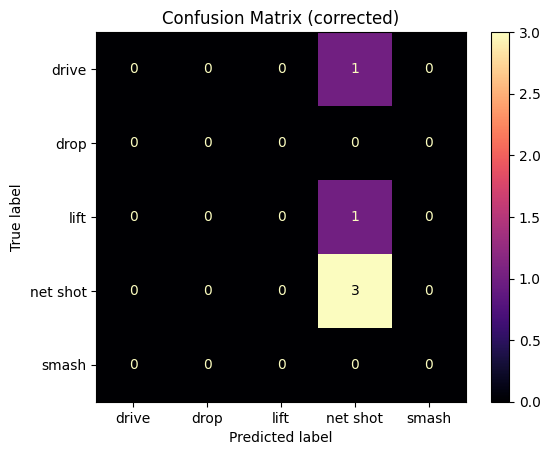

In [ ]:
# Ensure you're using the correct class order
class_names = label_encoder.classes_
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassified samples: {len(misclassified_indices)}")

# Optional: classification report
labels = np.arange(len(label_encoder.classes_))  # [0, 1, 2, 3, 4]
print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=label_encoder.classes_,
    zero_division=0  # optional: avoids warnings on missing classes
))

# Specify labels explicitly to enforce correct order
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# Plot with correct class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='magma')
plt.title("Confusion Matrix (corrected)")
plt.show()

# To Do

- generate more training data (manual labeling)